In [9]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#from scipy.interpolate import interp1d
#from scipy.sparse import coo_matrix


In [5]:
def sigmaZeros(sigTtab, sig0tab, aDen, SigEscape):
    # Number of energy groups
    ng = 421

    # Define number of isotopes in the mixture
    nIso = len(aDen)

    # first guess for sigma-zeros is 1e10 (infinite dilution)
    sig0 = np.ones((nIso, ng)) * 1e10

    # Loop over energy group
    for ig in range(ng):
        # Error to control sigma-zero iterations
        err = 1e10
        nIter = 0

        # sigma-sero iterations until the error is below selected tolerance (1e-6)
        while err > 1e-6:
            # Loop over isotopes
            for iIso in range(nIso):
                # Find cross section for the current sigma-zero by interpolating
                # in the table
                if len(sig0tab[iIso]) == 1:
                    sigT = sigTtab[iIso][0, ig]
                else:
                    log10sig0 = np.minimum(10, np.maximum(0, np.log10(sig0[iIso, ig])))
                    sigT = sp.interpolate.interp1d(np.log10(sig0tab[iIso]), sigTtab[iIso][:, ig], kind='linear')(log10sig0)
                sigT = np.asscalar(sigT)
                sigTtab[iIso][np.isnan(sigTtab[iIso])] = 0

            err = 0
            # Loop over isotopes
            for iIso in range(nIso):
                # Find the total macroscopic cross section for the mixture of
                # the background isotopes
                sum = 0
                # Loop over background isotopes
                for jIso in range(nIso):
                    if jIso != iIso:
                        sum += sigTtab[jIso][ig] * aDen[jIso]

                tmp = (SigEscape + sum) / aDen[iIso]
                err += (1 - tmp / sig0[iIso, ig]) ** 2
                sig0[iIso, ig] = tmp

            err = np.sqrt(err)
            nIter += 1
            if nIter > 100:
                print('Error: too many sigma-zero iterations.')
                return

    return sig0

In [6]:
def interpSigS(jLgn, s, Sig0):
    # number of energy groups
    ng = 421

    # number of sigma-zeros
    nSig0 = len(s['sig0'])
    if nSig0 == 1:
        sigS = s['sigS'][jLgn][0]
    else:
        tmp1 = np.zeros((nSig0, ng*ng))
        for iSig0 in range(nSig0):
            ifrom, ito, tmp1[iSig0,:] = sp.sparse.find(s['sigS'][jLgn][iSig0])
        
        # number of non-zeros in a scattering matrix
        nNonZeros = tmp1.shape[1]
        tmp2 = np.zeros(nNonZeros)
        for i in range(nNonZeros):
            log10sig0 = min(10, max(0, np.log10(Sig0[ifrom[i]])))
            tmp2[i] = sp.interpolate.interp1d(np.log10(s['sig0']), tmp1[:,i], kind='linear')(log10sig0)
        
        sigS = sp.sparse.coo_matrix((tmp2, (ifrom, ito)), shape=(ng, ng)).toarray()

    return sigS


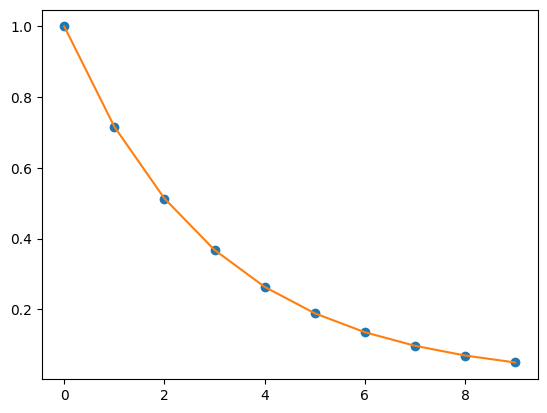

In [13]:
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = sp.interpolate.interp1d(x, y)
plt.plot(x, y, 'o', x, y, '-')
plt.show()

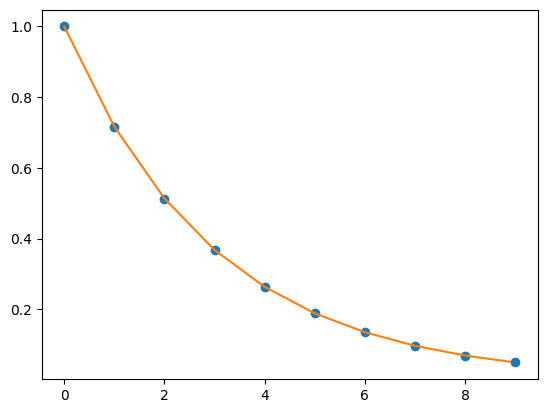

In [11]:
xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [ ]:
# number of energy groups
H2OU_ng = 421

# Path to microscopic cross section data:
micro_XS_path = '../01.Micro.XS.421g'

# Call the functions for H2O and B isotopes and store the data in the
# structures. As an example it is done below for temperature of 294K,
# pressure of 7 MPa and boron concentration of 760 ppm.
# Change when other parameters needed.
# Open the HDF5 files
hdf5_H01 = h5py.File('micro_H_001__294K.h5', 'r')
hdf5_O16 = h5py.File('micro_O_016__294K.h5', 'r')
hdf5_U235 = h5py.File('micro_U_235__294K.h5', 'r')

# Read the datasets from the HDF5 files
H01 = hdf5_H01['dataset_name'][()]
O16 = hdf5_O16['dataset_name'][()]
U235 = hdf5_U235['dataset_name'][()]

# Close the HDF5 files
hdf5_H01.close()
hdf5_O16.close()
hdf5_U235.close()

# Something similar maybe?
#H01 = np.load(micro_XS_path + '/micro_H_001__294K.npy')
#O16 = np.load(micro_XS_path + '/micro_O_016__294K.npy')
#U235 = np.load(micro_XS_path + '/micro_U_235__294K.npy')
"""
H2OU_temp = 294  # K
H2OU_p = 0.1  # MPa
H2OU_Uconc = 1000e-6  # 1e-6 = 1 ppm
H2OU_eg = H01['eg']

# Mass of one "average" H2OU molecule in atomic unit mass [a.u.m.]:
H2OU_aw = 2 * H01['aw'] + O16['aw'] + H2OU_Uconc * U235['aw']

# Path to steam-water properties:
XSteam_path = '../00.XSteam'

# The function returns water density at specified pressure (MPa) and
# temperature (C):
import sys
sys.path.append(XSteam_path)
from XSteam import XSteam
steamTable = XSteam(XSteam_path)
density = steamTable.rho_pt(H2OU_p*10, H2OU_temp-273)

# The water density:
H2OU_den = density*1e-3  # [g/cm3]
rho = H2OU_den*1.0e-24  # [g/(barn*cm)]
rho = rho / 1.660538e-24  # [(a.u.m.)/(barn*cm)]
rho = rho / H2OU_aw  # [number of H2O molecules/(barn*cm)]

# The names of fissionable isotopes and oxygen
H2OU_isoName = ['H01', 'O16', 'U235']

# The number densities of isotopes:
H2OU_numDen = [2*rho, rho, rho*H2OU_Uconc]

# Prepare for sigma-zero iterations:
sigTtab = [H01['sigT'], O16['sigT'], U235['sigT']]
sig0tab = [H01['sig0'], O16['sig0'], U235['sig0']]
aDen = H2OU_numDen

# SigEscape -- escape cross section, for simple convex objects (such as
# plates, spheres, or cylinders) is given by S/(4V), where V and S are the
# volume and surface area of the object, respectively
SigEscape = 0

print('Sigma-zero iterations. ')
H2OU_sig0 = sigmaZeros(sigTtab, sig0tab, aDen, SigEscape)
print('Done.\n')
"""